# Deepdive notebook converted to plot proper figures

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from numpy import core
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from functions import *
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch


In [2]:
# create meshgrid from -1.5 to 1.5


def artificial_landscape_CAF(coordinates, syll, centers, target_width, n_distractors, heights=None, means=None, spreads=None):
    """
    Independent function to create artificial landscape for CAF experiment.
    
    Parameters:
    - coordinates: array of shape (N, 2) with x,y coordinates
    - syll: syllable index
    - centers: array of shape (N_SYLL, 2) with center positions for each syllable
    - target_width: float, width parameter for the main target gaussian
    - n_distractors: int, number of distractor hills
    - heights: array of shape (N_SYLL, n_distractors), heights of distractor hills
    - means: array of shape (N_SYLL, n_distractors, 2), means of distractor hills
    - spreads: array of shape (N_SYLL, n_distractors), spreads of distractor hills
    """
    center = centers[syll, :]
    reward_scape = gaussian(coordinates, 1, center, target_width)
    if n_distractors == 0:
        return reward_scape
    hills = []
    hills.append(reward_scape)
    for i in range(n_distractors):
        height = heights[syll, i]
        mean = means[syll, i,:]
        spread = spreads[syll, i]
        hills.append(gaussian(coordinates, height, mean, spread))
    
    # Create a mask for coordinates within the specified range
    # This applies to the y-coordinates (coordinates[1])
    result = np.maximum.reduce(hills)
    
    # Create mask: True where y-coordinates are between -0.5 and 0.5
    mask = (coordinates[1] >= -0.0) & (coordinates[1] <= 0.0)
    
    # Apply the mask - set values to 0 where mask is True
    # You can change this behavior as needed (e.g., multiply by factor, set to different value, etc.)
    result = np.where(mask, 0, result)
    
    return result

# # Example usage with sample parameters
# # Set up example parameters for demonstration
# N_SYLL = 1  # number of syllables
# n_distractors = 10  # number of distractor hills
# target_width = 0.3  # width of main target

# # Create sample data
# np.random.seed(42)  # for reproducible results
# centers = np.random.uniform(-0.9, 0.9, (N_SYLL, 2))
# heights = np.random.uniform(0.2, 0.7, (N_SYLL, n_distractors))
# means = np.random.uniform(-1, 1, (N_SYLL, n_distractors, 2))
# spreads = np.random.uniform(0.1, 0.6, (N_SYLL, n_distractors))

# x, y = np.meshgrid(np.linspace(-1.5, 1.5, 20), np.linspace(-1.5, 1.5, 20))
# X, Y = np.meshgrid(x, y)



# Z = artificial_landscape_CAF([X, Y], 0, centers, target_width, n_distractors, heights, means, spreads)

# fig, axs = plt.subplots(figsize=(10, 9))
# contour = axs.contourf(X, Y, Z, levels=10, cmap='viridis')
# fig.colorbar(contour, ax=axs, label='Reward')


In [3]:
from env_lite import Environment
from model import NN
import json
import numpy as np

In [4]:
# load parameters from json file
params_path = "params.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

In [5]:
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 396 # SEED 3 both jump and without jump learn 
print(f'Random seed is {RANDOM_SEED}')
# np.random.seed(RANDOM_SEED)

Random seed is 396


In [6]:
obj = Environment(RANDOM_SEED, parameters, NN)
obj.run(parameters, True)

  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:16<00:00,  3.65it/s]


In [7]:
obj.hvc_bg_array_all[1,-1, 0,:].shape

(8,)

In [8]:
obj.model.W_hvc_bg[:,:].shape

(100, 50)

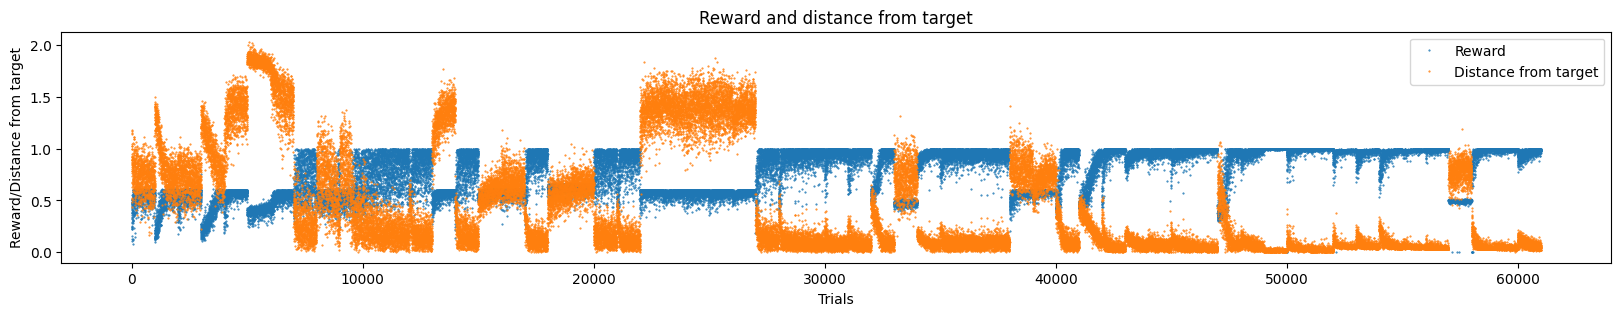

In [9]:
plt.figure(figsize=(20, 3))     
for syll in range(N_SYLL):
    plt.plot(obj.rewards[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None', label='Reward')
    plt.plot(obj.dist_from_target[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None', label='Distance from target')        
plt.legend()    
plt.xlabel('Trials')    
plt.ylabel('Reward/Distance from target')   
plt.title('Reward and distance from target')        
plt.show()

In [10]:
def plot_interal_all(obj, syll):
    fig, ax = plt.subplots(7, 1, figsize=(10, 10))  
    
    ax[0].plot(obj.rewards[:, :, syll].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, linestyle='None')
    ax[0].hlines(0.7, 0, obj.DAYS * obj.TRIALS, colors='r', linestyles='dashed')
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Reward')
    
    ax[1].plot(obj.hvc_bg_array_all[:, :, syll, 0,0].reshape(obj.DAYS * obj.TRIALS))
    ax[1].set_ylim(-1, 1)
    ax[1].set_ylabel('HVC BG weights')
    
    ax[2].plot(obj.bg_all[:, :, syll, 0].reshape(obj.DAYS * obj.TRIALS), '.', markersize=0.5, linestyle='None')
    ax[2].set_ylim(-1, 1)
    ax[2].set_ylabel('BG output')
    
    ax[3].plot(obj.hvc_ra_array_all[:, :, syll, 0, 0].reshape(obj.DAYS * obj.TRIALS))
    ax[3].set_ylim(-1, 1)
    ax[3].set_ylabel('HVC RA weights')
    
    ax[4].plot(obj.actions[:, :, syll, 0].reshape(obj.DAYS * obj.TRIALS))
    ax[4].plot(obj.actions[:, :, syll, 1].reshape(obj.DAYS * obj.TRIALS))
    ax[4].plot(obj.centers[syll, 0] * np.ones(obj.TRIALS * obj.DAYS))
    ax[4].plot(obj.centers[syll, 1] * np.ones(obj.TRIALS * obj.DAYS))
    ax[4].legend(['x target', 'y target'])
    ax[4].set_ylabel('Motor Output')
    ax[4].set_ylim(-1, 1)
    
    ax[5].plot(obj.ra_all[:, :, syll, 10].reshape(obj.DAYS * obj.TRIALS))
    ax[5].set_ylim(-1, 1)
    ax[5].set_ylabel('RA activity')
    ax[6].set_xlabel('Days')
    
    potentiation_factor_all = np.repeat(obj.potentiation_factor_all, N_DAILY_MOTIFS, axis=0)
    ax[6].plot(potentiation_factor_all[:, syll, 0, 0].reshape(obj.DAYS * obj.TRIALS), '.', markersize=1, label='POTENTIATION', alpha=0.1)
    ax[6].set_ylabel('Potentiation factor')
    
    for i in range(1, 6):
        ax[i].set_xticks(range(0, obj.DAYS * obj.TRIALS, 10 * obj.TRIALS), range(0, obj.DAYS, 10))
    
    fig.suptitle(f'Results SEED:{obj.seed} syllable: {syll}', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type: ignore
    plt.show()


# plot_interal_all(obj, 0)

In [11]:

# for i in range(N_SYLL):?
    # obj.save_dw_day(i)
    # obj.save_trajectory(i)
    

In [12]:
# raise ValueError

In [13]:
N_DAYS_INTACT = DAYS - 1
N_TRIAL_PER_SYLL = N_DAILY_MOTIFS * N_DAYS_INTACT
N_INTACT_TRIALS = N_TRIAL_PER_SYLL * N_SYLL
N_LESION_DAYS = 1
N_TOTAL_TRIALS = N_INTACT_TRIALS + N_LESION_DAYS * N_DAILY_MOTIFS * N_SYLL
DAYS = N_DAYS_INTACT + N_LESION_DAYS

In [14]:
# # modes
# ANNEALING = 1
# ANNEALING_SLOPE = 4
# ANNEALING_MID = 3
# ANNEALING_MID_DECAY = 0.0 # exponential decay wrt days
# HEBBIAN_LEARNING = True
# LOG_NORMAL = False
# balance_factor = 3
# BG_influence = True

# # parameters
# REWARD_WINDOW = 10
# BG_NOISE = 0.1

# # Landscape
# LANDSCAPE = 0 # 0 for artificiall; 1 for syrinx

# # Run paraneters
# N_DISTRACTORS = 10
# LEARING_RATE_RL = 0.1
# LEARNING_RATE_HL = 2e-5 # small increase compared to CODE_8

# # sigmoid layer parameters
# BG_SIG_SLOPE = 2.5  # uniform output 
# BG_sig_MID = 0
# RA_SIG_SLOPE = 18 # most steep such that MC output is not skewed
# RA_sig_MID = 0
# # Sigmoid on MC is removed
# # MC_SIG_SLOPE = 1 # 5 if lesser -> more difficult to climb the hill, assymptotes before 
# # MC_sig_MID = 0

# # layer sizes
# HVC_SIZE = 100
# BG_SIZE = 50
# RA_SIZE = 100 
# MC_SIZE = 2
# N_RA_CLUSTERS = MC_SIZE
# N_BG_CLUSTERS = 2
# LIMIT = 1.5

In [15]:
# # Model
# class NN:
#     def __init__(self, hvc_size, bg_size, ra_size, mc_size):
#         if LOG_NORMAL:
#             self.W_hvc_bg = sym_lognormal_samples(minimum = -1, maximum = 1, size = (hvc_size, bg_size)) # changing from -1 to 1 
#             self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
#             self.W_bg_ra = lognormal_weight((bg_size, ra_size)) # const from 0 to 1
#             self.W_ra_mc = lognormal_weight((ra_size, mc_size)) # const from 0 to 1
#         else:
#             self.W_hvc_bg = np.random.uniform(-1,1,(hvc_size, bg_size)) # changing from -1 to 1 
#             self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
#             self.W_bg_ra = np.random.uniform(0, 1, (bg_size, ra_size)) # const from 0 to 1
#             self.W_ra_mc = np.random.uniform(0, 1, (ra_size, mc_size)) # const from 0 to 1
#         # Creating channels
#         # channel from ra to mc
#         for i in range(N_RA_CLUSTERS):
#             segPath = np.diag(np.ones(N_RA_CLUSTERS, int))[i]
#             self.W_ra_mc[i*ra_size//N_RA_CLUSTERS : (i+1)*ra_size//N_RA_CLUSTERS] *= segPath
#         # channel from bg to ra such that motor cortex components are independent of each other
#         for i in range(N_BG_CLUSTERS):
#             segPath = np.diag(np.ones(N_BG_CLUSTERS, int))[i]
#             self.W_bg_ra[i*bg_size//N_BG_CLUSTERS : (i+1)*bg_size//N_BG_CLUSTERS] *= [j for j in segPath for r in range(RA_SIZE//N_BG_CLUSTERS)]

#         self.hvc_size = hvc_size
#         self.bg_size = bg_size
#         self.ra_size = ra_size
#         self.mc_size = mc_size  
#         self.ra_cluster_size = ra_size // N_RA_CLUSTERS
#         self.bg_cluster_size = bg_size // N_BG_CLUSTERS
#         self.bg_influence = BG_influence
            
#     def forward(self, hvc_array):
#         self.hvc = hvc_array
#         if LANDSCAPE == 0: 
#             span = 1.5
#         else:
#             span = 1
#         # count number of 1 in hvc, divide bg by that number
#         num_ones = np.count_nonzero(hvc_array == 1)
#         self.bg = new_sigmoid(np.dot(hvc_array/num_ones, self.W_hvc_bg) + np.random.normal(0, BG_NOISE, self.bg_size), m = BG_SIG_SLOPE, a = BG_sig_MID)
#         self.ra = new_sigmoid(np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor * self.bg_influence + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING, m = RA_SIG_SLOPE, a = RA_sig_MID) 
#         self.mc = span*np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)) # outputs to +-0.50
#         ''' even after BG cut off, output should remain still the same'''
#         # below code is only for testing without sigmoidal functions
#         # self.mc = new_sigmoid(np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)), m = MC_SIG_SLOPE, a = MC_sig_MID)
#         # self.bg = np.dot(hvc_array/num_ones, self.W_hvc_bg)  #outputs to +-0.98
#         # self.ra = np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor  + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING #outputs to +-0.40
#         return self.mc, self.ra, self.bg

In [16]:
# class Environment:
#     def __init__(self, hvc_size, bg_size, ra_size, mc_size, seed):
#         self.hvc_size = hvc_size
#         self.bg_size = bg_size
#         self.ra_size = ra_size
#         self.mc_size = mc_size
#         self.seed = seed
#         self.model = NN(hvc_size, bg_size, ra_size, mc_size)
#         # landscape parameters
#         if LANDSCAPE == 0: # artificial landscape
#             self.centers = np.random.uniform(-0.9, 0.9, (N_SYLL, 2))
#             self.heights = np.random.uniform(0.2, 0.7, (N_SYLL, N_DISTRACTORS))
#             self.means = np.random.uniform(-1, 1, (N_SYLL,N_DISTRACTORS, 2))
#             self.spreads = np.random.uniform(0.1, 0.6, (N_SYLL, N_DISTRACTORS))
#         else: # Syrinx landscape
#             if N_SYLL > 4:
#                 raise ValueError('Only 4 syllables are available in the syrinx landscape')
#             self.syrinx_contours = []
#             self.syrinx_targets = []
#             for syll in range(N_SYLL):
#                 base = np.load(f"contours/Syll{syll+1}.npy")
#                 Z, target = make_contour(base)
#                 self.syrinx_contours.append(Z)
#                 self.syrinx_targets.append(target)
#                 self.centers = np.array(self.syrinx_targets)
            
#         # data storage
#         self.rewards = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
#         self.actions = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.mc_size))
#         self.hvc_bg_array = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
#         self.hvc_bg_array_all = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.hvc_size, self.bg_size))   
#         self.bg_out = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
#         self.hvc_ra_array = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
#         self.hvc_ra_array_all = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.hvc_size, self.ra_size))   
#         self.ra_out = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
#         self.RPE = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL)) 
#         self.RPE_SUM = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))
#         self.ra_all = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.ra_size))
#         self.bg_all = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL, self.bg_size))
#         self.dw_day_array = np.zeros((DAYS, N_SYLL))
#         self.pot_array = np.zeros((DAYS, N_SYLL))
#         self.annealing_mids = np.zeros((DAYS, N_DAILY_MOTIFS, N_SYLL))

#     def artificial_landscape(self, coordinates, syll):
#         center = self.centers[syll, :]
#         reward_scape = gaussian(coordinates, 1, center, 0.3)
#         if N_DISTRACTORS == 0:
#             return reward_scape
#         hills = []
#         hills.append(reward_scape)
#         for i in range(N_DISTRACTORS):
#             height = self.heights[syll, i]
#             mean = self.means[syll, i,:]
#             spread = self.spreads[syll, i]
#             hills.append(gaussian(coordinates, height, mean, spread))
#         return np.maximum.reduce(hills)
    
#     def syrinx_landscape(self, coordinates, syll, n = 256):  
#         contour = self.syrinx_contours[syll]
#         target_pos = self.syrinx_targets[syll]
#         x, y = coordinates[0], coordinates[1]
#         x = max(min(x, 0.999), -1)
#         y = max(min(y, 0.999), -1)
#         x = int((x + 1) / 2 * n)
#         y = int((y + 1) / 2 * n)
#         return contour[x, y]

        
#     def get_reward(self, coordinates, syll):
#         # landscape creation and reward calculation
#         if LANDSCAPE == False:
#             return self.artificial_landscape(coordinates, syll)
#         else:
#             return self.syrinx_landscape(coordinates, syll)
     
#     def run(self, learning_rate, learning_rate_hl, annealing = False):
#         # modes 
#         self.annealing = annealing
#         self.model.bg_influence = True
#         # each day, 1000 trial, n_syll syllables
#         for day in tqdm(range(DAYS)):
#             dw_day = np.zeros(N_SYLL)
#             self.model.bg_influence = True
#             if day >= DAYS: 
#                 self.model.bg_influence = False # BG lesion on the last day
#             sum_RPE = 0
#             for iter in range(N_DAILY_MOTIFS):
#                 for syll in range(N_SYLL):
#                     # input from HVC is determined by the syllable
#                     input_hvc = np.zeros(HVC_SIZE)
#                     input_hvc[syll] = 1
#                     # reward, action and baseline
#                     action, ra, bg = self.model.forward(input_hvc)
#                     reward = self.get_reward(action, syll)
#                     self.rewards[day, iter, syll] = reward
#                     self.actions[day, iter, syll,:] = action
#                     reward_baseline = 0
#                     if iter < REWARD_WINDOW and iter > 0:
#                         reward_baseline = np.mean(self.rewards[day, :iter, syll])
#                     elif iter >= REWARD_WINDOW:
#                         reward_baseline = np.mean(self.rewards[day, iter-REWARD_WINDOW:iter, syll])
#                     # Updating weights
#                     # RL update
#                     dw_hvc_bg = learning_rate*(reward - reward_baseline)*input_hvc.reshape(self.hvc_size,1)*self.model.bg * self.model.bg_influence # RL update
#                     self.model.W_hvc_bg += dw_hvc_bg
#                     # HL update
#                     dw_hvc_ra = learning_rate_hl*input_hvc.reshape(self.hvc_size,1)*self.model.ra*HEBBIAN_LEARNING # lr is supposed to be much smaller here
#                     self.model.W_hvc_ra += dw_hvc_ra
#                     # bound weights between +-1
#                     # np.clip(self.model.W_hvc_bg, -1, 1, out = self.model.W_hvc_bg)
#                     # np.clip(self.model.W_hvc_ra, -1, 1, out = self.model.W_hvc_ra)
#                     np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_bg, 1, out = self.model.W_hvc_bg), -1, out = self.model.W_hvc_bg) # type: ignore
#                     np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_ra, 1, out = self.model.W_hvc_ra), -1, out = self.model.W_hvc_ra) # type: ignore
#                     # storing values for plotting
#                     self.RPE[day, iter, syll] = reward - reward_baseline        
#                     sum_RPE += reward - reward_baseline 
#                     self.RPE_SUM[day, iter, syll] = sum_RPE
#                     dw_day[syll] += np.mean(np.abs(dw_hvc_bg))
#                     self.hvc_bg_array[day, iter, syll] = self.model.W_hvc_bg[syll,1]
#                     self.bg_out[day, iter, syll] = bg[1]
#                     self.hvc_ra_array[day, iter, syll] = self.model.W_hvc_ra[syll,1]
#                     self.hvc_ra_array_all[day, iter, syll, :] = self.model.W_hvc_ra[syll,:]
#                     self.hvc_bg_array_all[day, iter, syll, :] = self.model.W_hvc_bg[syll,:]
#                     self.ra_out[day, iter, syll] = ra[0]
#                     self.ra_all[day, iter, syll, :] = ra
#                     self.bg_all[day, iter, syll, :] = bg

#             # if day % 1 == 0:   
#             #     tqdm.write(f'Day: {day}, Action: {action}, Reward: {reward}, Reward Baseline: {reward_baseline}')  
#             # Annealing
#             if self.annealing:
#                 for syll in range(N_SYLL):
#                     ''' input daily sum, output scaling factor for potentiation'''
#                     # calculating potentiation 
#                     d = dw_day[syll]*100 # scaling up to be comparable
#                     p = 1 * sigmoid(1*d, m = ANNEALING_SLOPE, a = ANNEALING_MID)
#                     potentiation_factor = np.zeros((self.hvc_size))
#                     potentiation_factor[syll] = 1-p 
#                     # implementing night weight changes
#                     night_noise = np.random.uniform(-1, 1, self.bg_size) # make it lognormal
#                     dw_night = LEARING_RATE_RL*potentiation_factor.reshape(self.hvc_size,1)*night_noise*10*self.model.bg_influence
#                     self.model.W_hvc_bg += dw_night
#                     self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
#                     # storing values
#                     self.pot_array[day, syll] = 1-p
#                     self.dw_day_array[day, syll] = d
                
#     def generate_trajectory(self, syll):
#         x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
#         limit = 1.5
#         x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
#         X, Y = np.meshgrid(x, y)
#         Z = self.get_reward([X, Y], syll)
#         return X,Y,Z, x_traj, y_traj, syll    
    
#     def plot_trajectory(self, X, Y, Z, x_traj, y_traj, syll):
#         fig, axs = plt.subplots(figsize=(10, 9))
#         path = TextPath((0, 0), f'Syllable: {syll}', size=12)
#         patch = PathPatch(path)
#         # generate grid 
#         limit = 1.5
#         # Plot contour
#         cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
#         contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
#         fig.colorbar(contour, ax=axs, label='Reward')
        
#         # plot trajectory
#         axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
#         axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
#         axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
#         axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=20, c='y', marker='x', label='target')  # type: ignore
#         # labels
#         axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')   
#         axs.set_xlabel('x')
#         axs.set_ylabel('y')
#         axs.legend()
#         plt.tight_layout()
#         plt.show()

#     def generate_results(self, syll):   
#         return self.ra_all[:,:,syll,:].reshape(DAYS*N_DAILY_MOTIFS, self.ra_size)
        
#     def plot_results(self, syll):
#         fig, axs = plt.subplots(6, 1, figsize=(10, 15))
#         axs[0].plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, linestyle='None')
#         axs[0].hlines(0.7, 0, DAYS*N_DAILY_MOTIFS, colors='r', linestyles='dashed')
#         axs[0].set_ylim(0, 1)
#         axs[0].set_ylabel('Reward')
#         axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[1].set_ylim(-1, 1)
#         axs[1].set_ylabel('HVC BG weights')
#         axs[2].plot(self.bg_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS),'.', markersize=0.5, linestyle='None')
#         axs[2].set_ylim(-1, 1)
#         axs[2].set_ylabel('BG output')
#         axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[3].set_ylim(-1, 1)
#         axs[3].set_ylabel('HVC RA weights')
#         axs[4].plot(self.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[4].plot(self.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[4].plot(self.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS))
#         axs[4].plot(self.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS))
#         axs[4].legend(['x target', 'y target'])
#         axs[4].set_ylabel('Motor Output')
#         axs[4].set_ylim(-1, 1)
#         axs[5].plot(self.ra_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[5].set_ylim(-1, 1)
#         axs[5].set_ylabel('RA activity')
#         fig.suptitle('Results', fontsize=20)
#         plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#         plt.show()
    
#     def plot_dw_day(self, syll):
#         if ANNEALING:
#             fig, axs = plt.subplots(4,1,figsize=(10, 15))
#             expanded_dw_day_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
#             expanded_pot_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
#             # Expand dw_day_array and pot_array to match the size of rewards
#             expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], DAYS*N_DAILY_MOTIFS// len(self.dw_day_array[:, syll]))
#             expanded_pot_array = np.repeat(self.pot_array[:, syll], DAYS*N_DAILY_MOTIFS// len(self.pot_array[:, syll]))
#             fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
#             axs[0].set_title(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')  
#             axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
#             axs[0].set_ylim(0,10)
#             axs[0].set_ylabel('dW_day')        
#             axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
#             axs[1].set_ylabel('Potentiation factor')
#             axs[2].plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
#             axs[2].set_ylabel('Rewards')
#             axs[2].set_ylim(0, 1)
#             axs[3].plot(self.RPE[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE', alpha = 0.1)               
#             axs[3].set_ylabel('RPE')
#             axs[3].set_ylim(-1, 1)
#             for i in range(4):
#                 axs[i].vlines(range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS), -3, 10, colors='b', linestyles='dashed')           
#             plt.tight_layout()
#             plt.show()

            
#             # plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
#             # plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
#             # plt.plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
#             # plt.xlabel('Days')
#             # plt.ylabel('dW_day')
#             # plt.legend()
#             # plt.show()  
        
#     def save_trajectory(self, syll):
#         fig, axs = plt.subplots(figsize=(10, 9))
#         # generate grid 
#         x, y = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
#         X, Y = np.meshgrid(x, y)
#         Z = self.get_reward([X, Y], syll)
#         # Plot contour
#         cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
#         contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
#         fig.colorbar(contour, ax=axs, label='Reward')
        
#         # plot trajectory
#         x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
#         axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
#         axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
#         axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
#         axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=20, c='y', marker='x', label='target')  # type: ignore
#         # labels
#         axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')
#         axs.set_xlabel('x')
#         axs.set_ylabel('y')
#         axs.legend()
#         plt.tight_layout()
#         # Create the "plots" directory if it doesn't exist
#         os.makedirs(save_dir, exist_ok = True)
#         # Clear previous plots (optional):
#         # for filename in os.listdir(save_dir):
#         #     if filename.startswith("trajectory") and filename.endswith(".png") or filename.endswith(".jpg"):
#         #         os.remove(os.path.join(save_dir, filename))
#         # Save the plot
#         plt.savefig(os.path.join(save_dir, f"trajectory_{RANDOM_SEED}_{syll}.png"))
#         plt.close()  # Close the plot to avoid memory leaks
        
#     def save_results(self, syll):
#         fig, axs = plt.subplots(6, 1, figsize=(10, 15))
#         axs[0].plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, linestyle='None')
#         axs[0].hlines(0.7, 0, DAYS*N_DAILY_MOTIFS, colors='r', linestyles='dashed')
#         axs[0].set_ylim(0, 1)
#         axs[0].set_ylabel('Reward')
#         axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[1].set_ylim(-1, 1)
#         axs[1].set_ylabel('HVC BG weights')
#         axs[2].plot(self.bg_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS),'.', markersize=0.5, linestyle='None')
#         axs[2].set_ylim(-1, 1)
#         axs[2].set_ylabel('BG output')
#         axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[3].set_ylim(-1, 1)
#         axs[3].set_ylabel('HVC RA weights')
#         axs[4].plot(self.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[4].plot(self.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[4].plot(self.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS))
#         axs[4].plot(self.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS))
#         axs[4].legend(['x target', 'y target'])
#         axs[4].set_ylabel('Motor Output')
#         axs[4].set_ylim(-1, 1)
#         axs[5].plot(self.ra_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
#         axs[5].set_ylim(-1, 1)
#         axs[5].set_ylabel('RA activity')
#         fig.suptitle(f'Results SEED:{RANDOM_SEED} syllable: {syll}', fontsize=20)
#         plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#         # Create the "plots" directory if it doesn't exist
#         os.makedirs(save_dir, exist_ok = True)
#         # Clear previous plots (optional):
#         # for filename in os.listdir(save_dir):
#         #     if filename.startswith("results") and filename.endswith(".png") or filename.endswith(".jpg"):
#         #         os.remove(os.path.join(save_dir, filename))
#         # Save the plot
#         plt.savefig(os.path.join(save_dir, f"results_{RANDOM_SEED}_{syll}.png"))
#         plt.close()  # Close the plot to avoid memory leaks
        
#     def save_dw_day(self, syll):
#         if ANNEALING:
#             expanded_dw_day_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
#             expanded_pot_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))
#             # Expand dw_day_array and pot_array to match the size of rewards
#             expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], DAYS*N_DAILY_MOTIFS// len(self.dw_day_array[:, syll]))
#             expanded_pot_array = np.repeat(self.pot_array[:, syll], DAYS*N_DAILY_MOTIFS// len(self.pot_array[:, syll]))
#             plt.title(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
#             plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
#             plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
#             plt.plot(self.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
#             plt.xlabel('Days')
#             plt.ylabel('dW_day')
#             plt.legend()
#             # Create the "plots" directory if it doesn't exist
#             os.makedirs(save_dir, exist_ok = True)
#             # # Clear previous plots (optional):
#             # for filename in os.listdir(save_dir):
#             #     if filename.startswith("dw") and filename.endswith(".png") or filename.endswith(".jpg"):
#             #         os.remove(os.path.join(save_dir, filename))
#             # Save the plot
#             plt.savefig(os.path.join(save_dir, f"dw_{RANDOM_SEED}_{syll}.png"))
#             plt.close()  # Close the plot to avoid memory leaks         
    

In [17]:
# obj = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
# obj.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING)

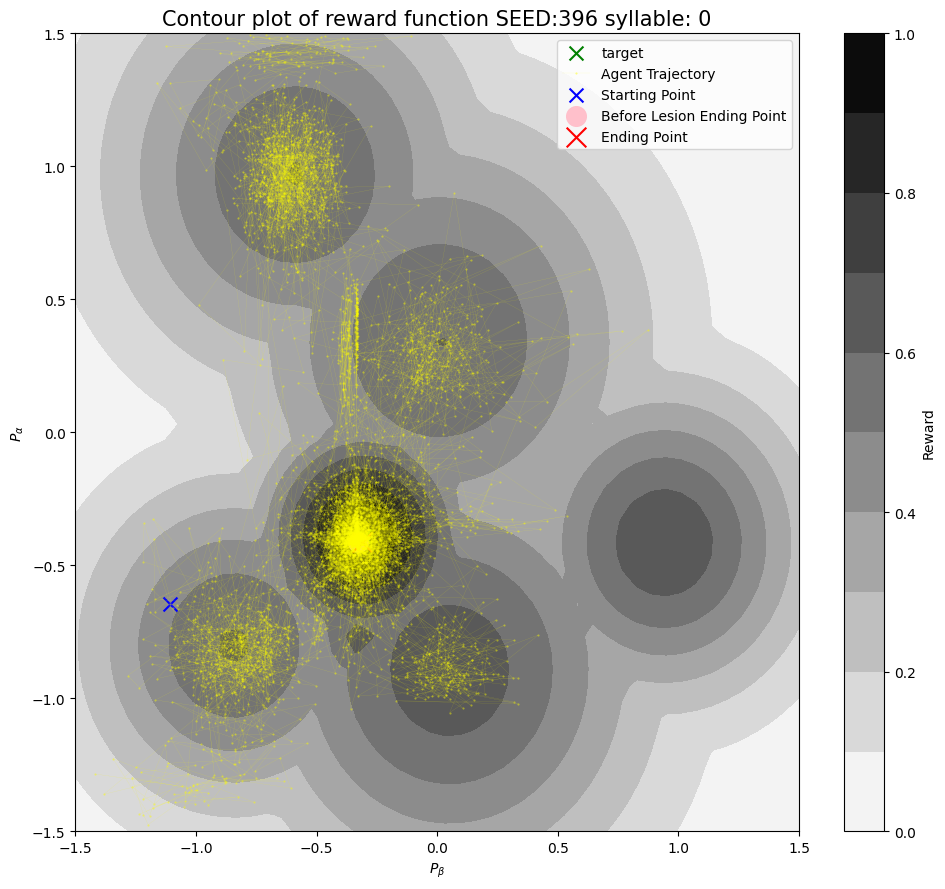

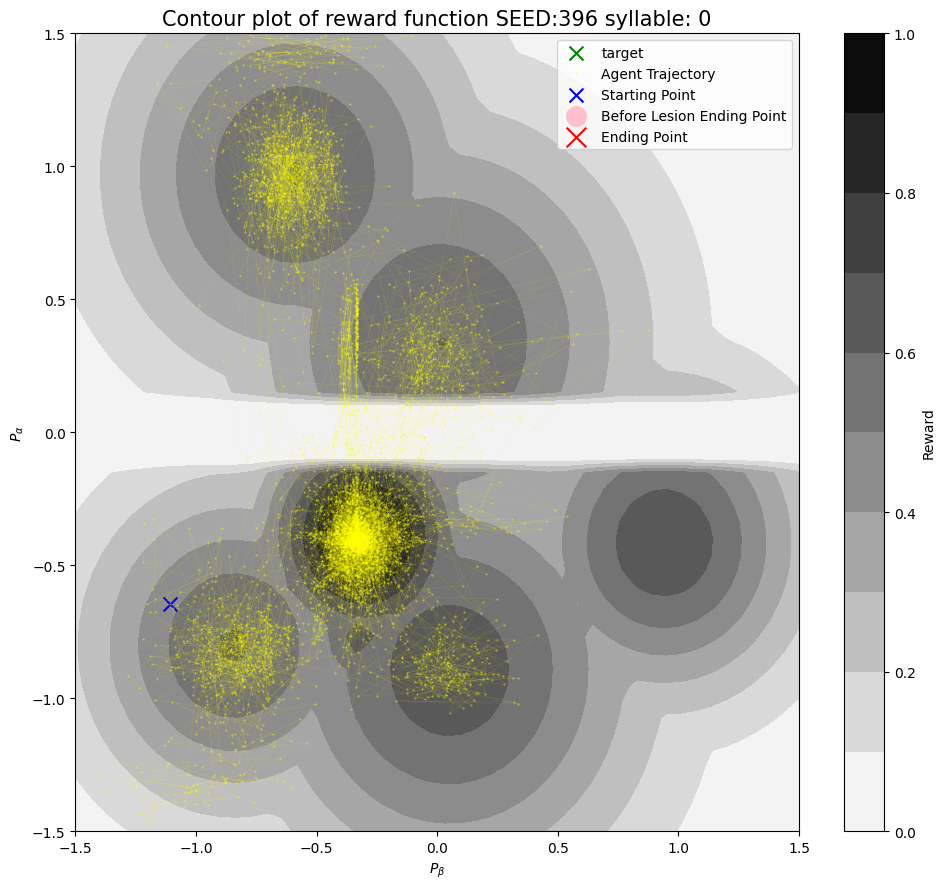

In [18]:
def plot_trajectory(syll):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'black'])
    if obj.LANDSCAPE == 0: # artificial landscape
        x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        # # plot trajectory
        # axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.1, marker = ".", linewidth = 0.1, markersize = 0.99) # Plot every 20th point for efficiency
        # axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
        # axs.scatter(x_traj[-1001], y_traj[-1001], s=100, c='pink', marker='x', label='Before Lesion Ending Point')
        # axs.scatter(x_traj[-5:], y_traj[-5:], s=100, c='r', marker='x', label='After Leison Point') # type: ignore
        axs.scatter(obj.centers[syll, 0], obj.centers[syll, 1], s=100, c='green', marker='x', label='target')  # type: ignore
    else: 
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        cs = plt.contourf(Z, cmap=cmap, extent=[-1, 1, -1, 1])
        fig.colorbar(cs, ax=axs, label='Reward')
        axs.scatter(target_pos[0], target_pos[1], s=100, c='green', marker='x', label='target')  # type: ignore
        # plot trajectory
    x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
    axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.5, linewidth = 0.1, marker='.', markersize = 0.99) # Plot every 20th point for efficiency
    axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
    axs.scatter(x_traj[-1001], y_traj[-1001], s=200, c='pink', marker='o', label='Before Lesion Ending Point')
    axs.scatter(x_traj[-1], y_traj[-1], s=200, c='r', marker='x', label='Ending Point') # type: ignore
    
    # labels
    axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}', fontsize = 15)
    axs.set_ylabel(r'$P_{\alpha}$')
    axs.set_xlabel(r'$P_{\beta}$')
    axs.legend()
    plt.tight_layout()
    plt.show()

def plot_trajectory_CAF(syll):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = LinearSegmentedColormap.from_list('white_to_black', ['white', 'black'])
    if obj.LANDSCAPE == 0: # artificial landscape
        x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward_CAF([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        # # plot trajectory
        # axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.1, marker = ".", linewidth = 0.1, markersize = 0.99) # Plot every 20th point for efficiency
        # axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
        # axs.scatter(x_traj[-1001], y_traj[-1001], s=100, c='pink', marker='x', label='Before Lesion Ending Point')
        # axs.scatter(x_traj[-5:], y_traj[-5:], s=100, c='r', marker='x', label='After Leison Point') # type: ignore
        axs.scatter(obj.centers[syll, 0], obj.centers[syll, 1], s=100, c='green', marker='x', label='target')  # type: ignore
    else: 
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        cs = plt.contourf(Z, cmap=cmap, extent=[-1, 1, -1, 1])
        fig.colorbar(cs, ax=axs, label='Reward')
        axs.scatter(target_pos[0], target_pos[1], s=100, c='green', marker='x', label='target')  # type: ignore
        # plot trajectory
    x_traj, y_traj = zip(*obj.actions[:,:, syll,:].reshape(-1, 2))
    axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.5, linewidth = 0.1, marker='.', markersize = 0.99) # Plot every 20th point for efficiency
    axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
    axs.scatter(x_traj[-1001], y_traj[-1001], s=200, c='pink', marker='o', label='Before Lesion Ending Point')
    axs.scatter(x_traj[-1], y_traj[-1], s=200, c='r', marker='x', label='Ending Point') # type: ignore
    
    # labels
    axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}', fontsize = 15)
    axs.set_ylabel(r'$P_{\alpha}$')
    axs.set_xlabel(r'$P_{\beta}$')
    axs.legend()
    plt.tight_layout()
    plt.show()

expanded_dw_day = np.zeros((DAYS*N_DAILY_MOTIFS))
def plot_dw_day(syll):
    if obj.annealing:
        fig, axs = plt.subplots(5,1,figsize=(6, 10))
        expanded_dw_day_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))

        expanded_pot_array = np.zeros((DAYS*N_DAILY_MOTIFS, N_SYLL))

        # Expand dw_day_array and pot_array to match the size of rewards
        expanded_dw_day_array = np.repeat(obj.dw_day_array[:, syll], DAYS*N_DAILY_MOTIFS// len(obj.dw_day_array[:, syll]))
        expanded_dw_day = expanded_dw_day_array.reshape(DAYS*N_DAILY_MOTIFS)
        expanded_pot_array = np.repeat(obj.pot_array[:, syll], DAYS*N_DAILY_MOTIFS// len(obj.pot_array[:, syll]))
        fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
        axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
        axs[0].plot(obj.annealing_mids[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS))
        axs[0].set_ylabel('dW_day = mean(abs(dw_hvc_bg))')         
        axs[0].set_ylim(0,9) 
        axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
        axs[1].set_ylabel('Size of night jump')
        axs[1].set_ylim(0, 1)
        axs[2].plot(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='Reward', alpha = 0.1)
        axs[2].set_ylabel('Rewards')
        axs[2].set_ylim(0, 1)
        axs[3].plot(obj.RPE[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE', alpha = 0.1)               
        axs[3].set_ylabel('RPE')
        axs[3].set_ylim(-1, 1)
        axs[4].plot(obj.RPE_SUM[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), '.', markersize=1, label='RPE_SUM', alpha = 0.1)
        axs[4].set_ylabel('RPE sum for a day')
        axs[4].set_ylim(-1, 4)    
        for i in range(5):
            axs[i].vlines(range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS), -3, 10, colors='black', linestyles='dashed', alpha = 0.1)           
        plt.tight_layout()
        plt.show()

for i in range(N_SYLL):
    plot_trajectory(i)
    plot_trajectory_CAF(i)

## Plottings

In [19]:
def running_mean(x, N=5):
        """ Returns the running average of an array. """
        rm = np.convolve(x, np.ones(N)/N, mode='valid')
        padded_rm = np.ones(np.shape(x)) * rm[-1]
        padded_rm[:rm.size] = rm

        return padded_rm

### Output

/tmp/ipykernel_1402676/288407329.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))


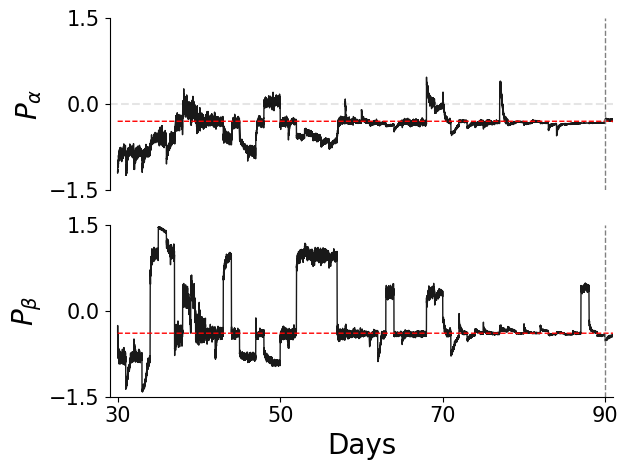

In [20]:
def plot_output(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)
    
    sk = N_SYLL
    LIMIT = 1.5

    # Display x axis in days
    x = np.arange(N_TOTAL_TRIALS)
    x = x/(N_DAILY_MOTIFS * N_SYLL)

    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    # Data
    for syll in range(N_SYLL):
        # motor outputs
        ax1.plot(running_mean(obj.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS), 10), color="black", lw=1, alpha=.9)
        ax2.plot(running_mean(obj.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS), 10), color="black", lw=1, alpha=.9)
    
    for syll in range(N_SYLL - 1):
        # target
        ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
        ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
    if N_SYLL > 1:
        ax1.plot(obj.centers[syll + 1, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
        ax2.plot(obj.centers[syll + 1, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1, label = 'Target')
    elif N_SYLL == 1:
        ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1, label = 'Target')
        ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
        
    # Axis beauty
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
#         ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.set_ylim(-LIMIT, LIMIT)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-LIMIT, 0, LIMIT])
    ax1.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([-LIMIT, 0, LIMIT])
    ax2.set_ylim(-LIMIT, LIMIT)
    ax2.tick_params(labelsize=15)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    # ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)
    
    ax2.set_ylabel(r'$P_{\beta}$', fontsize=20)
    ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
    plt.xticks(range(0, N_DAILY_MOTIFS*DAYS, 20*N_DAILY_MOTIFS), np.arange(30, DAYS+30, 20))
    plt.tight_layout()
    plt.show()

plot_output(obj)

### Reward

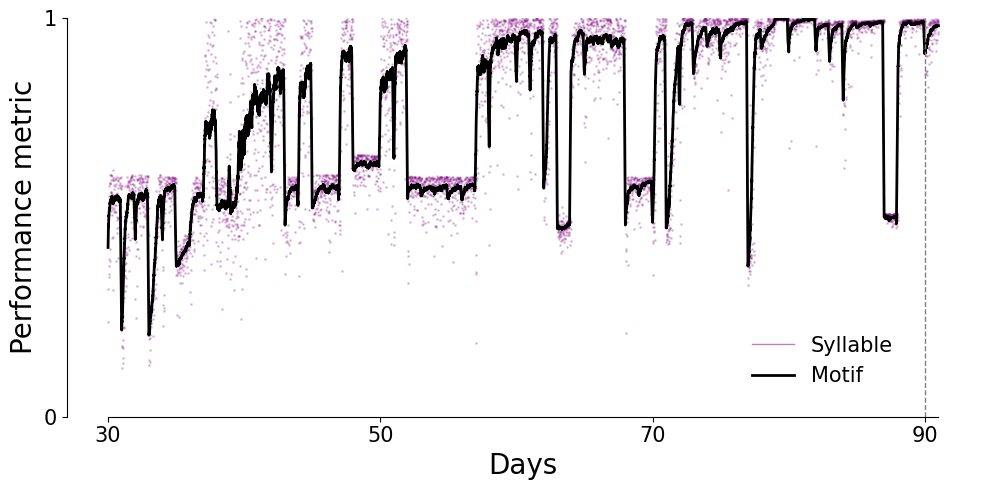

In [21]:
def plot_reward(obj):
    figure, ax = plt.subplots(1, figsize=(10, 5))
    # Display x axis in days

    # ax.set_title("Testing RL with normalized sigmoid")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # plotting rewards 
    for syll in range(N_SYLL):
        array = obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS)[::10]
        x_new = np.linspace(0, DAYS*N_DAILY_MOTIFS, len(array))
        ax.plot(x_new, array, linewidth=0, marker='.', color = 'purple', alpha = 0.2, markersize = 2)
    
    for syll in range(N_SYLL - 1):
        ax.plot(running_mean(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), 100), color="purple", lw=1, alpha=0.5)
    if N_SYLL > 1:
        ax.plot(running_mean(obj.rewards[:,:,syll + 1].reshape(DAYS*N_DAILY_MOTIFS), 100), color="purple", lw=1, alpha=0.5, label = 'Syllable')
    elif N_SYLL == 1:
        ax.plot(running_mean(obj.rewards[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS), 100), color="purple", lw=1, alpha=0.5, label = 'Syllable')
    ax.plot(running_mean(np.mean(obj.rewards[:,:,:].reshape(DAYS*N_DAILY_MOTIFS, N_SYLL), axis=1), 100),  color="black", lw=2, alpha=1, markersize=8, label='Motif')

    ax.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax.set_xlabel('Days', fontsize=20)
    ax.set_ylabel('Performance metric', fontsize=20)
    ax.set_ylim(0, 1)
    ax.tick_params(labelsize=15)
    ax.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    ax.set_yticks([0, 1])   
    ax.legend(bbox_to_anchor=[.925,0.25], fontsize=15, frameon=False)
    plt.tight_layout()
    plt.xticks(range(0, N_DAILY_MOTIFS*DAYS, 20*N_DAILY_MOTIFS), np.arange(30, 30+DAYS, 20), fontsize=15) # type: ignore
    plt.tight_layout()
    


plot_reward(obj)

### Hebbian learning trajectory

(61, 1000, 1, 8)


IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

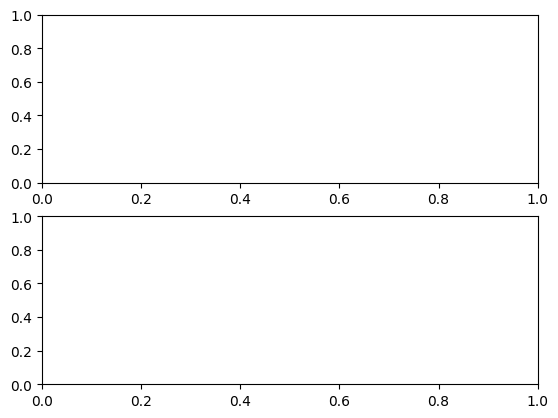

In [22]:
def plot_HL_traj(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)

    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    plot_array1 = obj.hvc_ra_array_all[:, :, 0, :, :].reshape(DAYS*N_DAILY_MOTIFS, obj.hvc_size*obj.ra_size)
    ax1.plot(plot_array1[::10, ::10], color='sienna', alpha=.5, linewidth=1)

    plot_array2 = obj.ra_all[:, :, 0, :].reshape(DAYS*N_DAILY_MOTIFS, obj.ra_size)
    ax2.plot(plot_array2[::100, ::10], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

    
    # # Axis beauty
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS//10, linestyle='--', color='grey', lw=1)
    ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS//100, linestyle='--', color='grey', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(labelsize=15)
    ax1.set_xticks([])
    ax1.set_yticks([-1, 0, 1])
    ax1.set_ylim(-1.1, 1.1)

    ax2.set_xticks([0, 20*N_DAILY_MOTIFS//100, 40*N_DAILY_MOTIFS//100, 60*N_DAILY_MOTIFS//100], np.arange(30, 30+DAYS, 20)) 
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([-1, 0, 1])
    ax2.tick_params(labelsize=15)

    # ax2.get_xaxis().set_ticks([0, 20, 40, 60])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS//100)



#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
    ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
    ax2.set_ylabel('RA\nactivity', fontsize=20)
    
print(obj.hvc_ra_array_all.shape)
plot_HL_traj(obj)

### Reinforcement Learning trajectory

In [ ]:
def plot_BG_volatility(obj):
    figure, (ax1) = plt.subplots(1, figsize=(10, 4))
    for syll in range(N_SYLL):
        ax1.plot(running_mean(obj.bg_out[:,:,syll].reshape(DAYS*N_DAILY_MOTIFS),30), color='grey', alpha=0.8, linewidth=2)
    # ax1.plot(running_mean(obj.bg_out[:,:,0].reshape(DAYS*N_DAILY_MOTIFS),30), color='grey', alpha=0.8, linewidth=2) 
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)     
    [ax1.axvline(x = k, linestyle='-', color='black', alpha=0.1) for k in range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS)]    
    ax1.set_xlabel('Days', fontsize=20)
    ax1.set_ylabel('BG output', fontsize=20)
    ax1.set_ylim(-1, 1)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-1, 0, 1])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)   
    ax1.set_ylim(-1, 1 )
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)

#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
    ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
#         ax2.set_ylabel('BG\nactivity', fontsize=20)

#         ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    
#         plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
    plt.xticks(range(0, N_DAILY_MOTIFS*DAYS, 20*N_DAILY_MOTIFS), np.arange(30,30+ DAYS, 20))    
    plt.tight_layout()

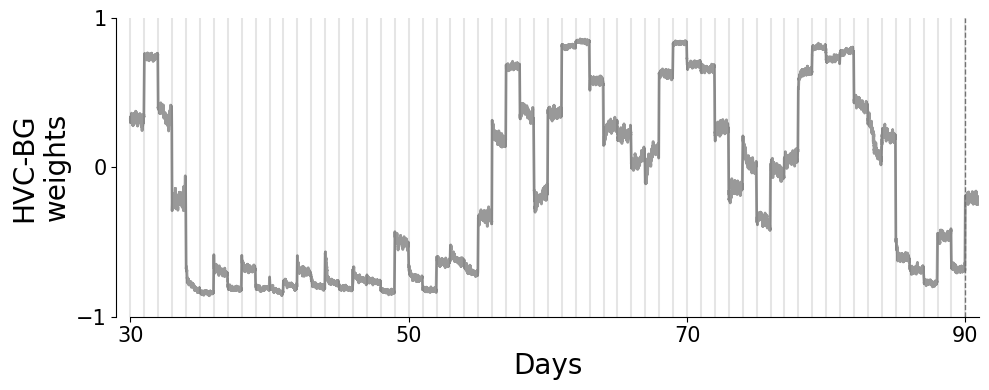

In [ ]:
plot_BG_volatility(obj)

### Hebbian Learning Activity

/tmp/ipykernel_29642/1938794867.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdGy_r')
/tmp/ipykernel_29642/1938794867.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


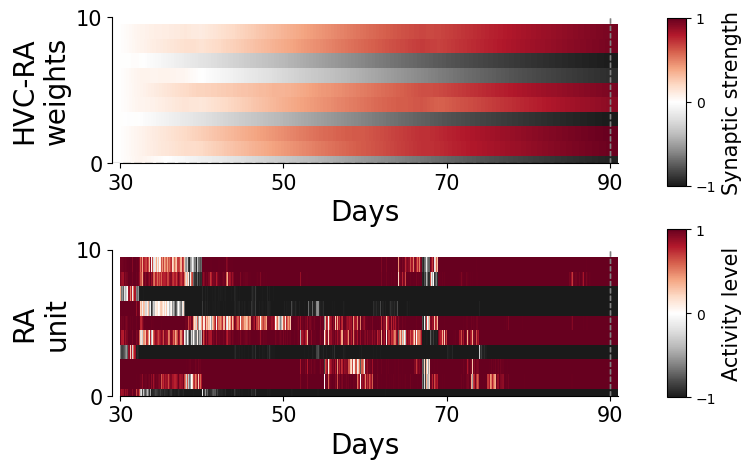

In [ ]:
def plot_HL2(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)
    ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    cm = plt.cm.get_cmap('RdGy_r')

    plot_array1 = obj.hvc_ra_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, obj.hvc_size*obj.ra_size)
    im1 = ax1.imshow(plot_array1[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none')

    plot_array2 = obj.ra_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, obj.ra_size)
    im2 = ax2.imshow(plot_array2[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none')

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35]) # type: ignore
    cbar = figure.colorbar(im2, cax=cbar_ax)
    cbar.set_label('Synaptic strength', fontsize=15)
    cbar.set_ticks([-1, 0, 1])
    
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35]) # type:ignore
    cbar = figure.colorbar(im2, cax=cbar_ax)
    cbar.set_label('Activity level', fontsize=15)
    cbar.set_ticks([-1, 0, 1])

    ax1.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)   
    ax2.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20))     
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([0, 10])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax1.set_ylim(0, 10)
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    ax2.set_ylim(0, 10)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 10])
    ax2.tick_params(labelsize=15)
    ax2.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20)) 
    ax2.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS) 

    ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
    ax2.set_ylabel('RA\nunit', fontsize=20) 
    plt.tight_layout()



# print(obj.hvc_ra_array_all.shape)    
# print(obj.hvc_ra_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, obj.hvc_size*obj.ra_size).shape)
plot_HL2(obj)



### Reinforcement learning Activity

/tmp/ipykernel_29642/1641897916.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('Greys')
/tmp/ipykernel_29642/1641897916.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


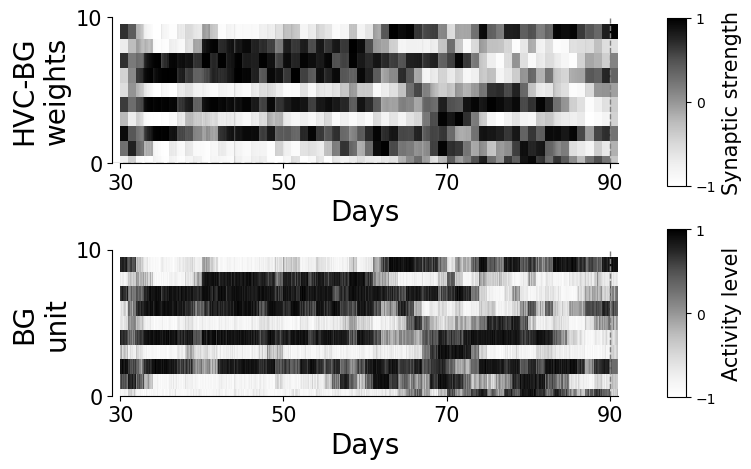

In [ ]:
def plot_BG(obj):
    figure, (ax1, ax2) = plt.subplots(2,1)

    cm = plt.cm.get_cmap('Greys')
    plot_array1 = obj.hvc_bg_array_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, obj.hvc_size*obj.bg_size)
    im1 = ax1.imshow(plot_array1[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none')
    plot_array2 = obj.bg_all.reshape(DAYS*N_DAILY_MOTIFS, N_SYLL, obj.bg_size)
    im2 = ax2.imshow(plot_array2[:,0,:10].T, cmap=cm, aspect='auto', interpolation='none')  

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Synaptic strength', fontsize=15)
    cbar.set_ticks([-1, 0, 1])
    
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Activity level', fontsize=15)
    cbar.set_ticks([-1, 0, 1])

    ax1.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)   
    ax2.vlines(N_DAYS_INTACT * N_DAILY_MOTIFS, 0, 10, color='grey', linestyle='--', lw=1)
    ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20))     
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([0, 10])
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax1.set_ylim(0, 10)
    ax1.set_xlabel('Days', fontsize=20)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    ax2.set_ylim(0, 10)
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([0, 10])
    ax2.tick_params(labelsize=15)
    ax2.set_xticks([0, 20*N_DAILY_MOTIFS, 40*N_DAILY_MOTIFS, 60*N_DAILY_MOTIFS], np.arange(30, 30 + DAYS, 20)) 
    ax2.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS) 

    ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
    ax2.set_ylabel('BG\nunit', fontsize=20)
    plt.tight_layout()
    

plot_BG(obj)

(61, 1000, 1, 100)


/tmp/ipykernel_29642/2466623827.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdGy_r')
/tmp/ipykernel_29642/2466623827.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


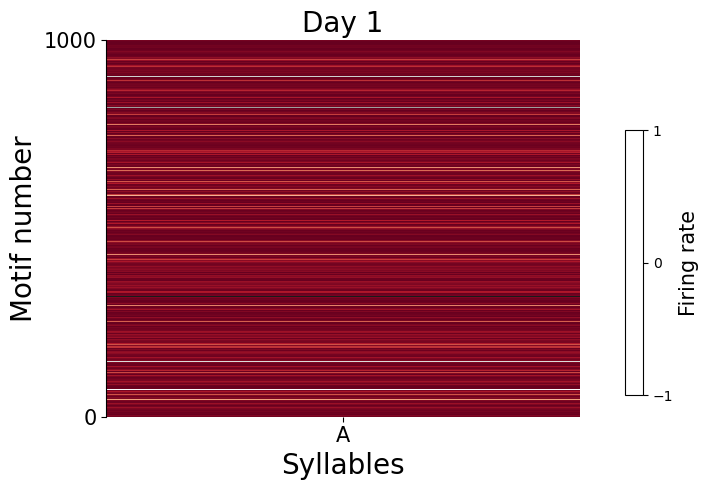

In [ ]:
def plot_HL_motifs_on_day(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(6,5))

    cm = plt.cm.get_cmap('RdGy_r')
    plot_array = obj.ra_all[day, :, :, 1].reshape(N_DAILY_MOTIFS, N_SYLL)
    im = ax1.imshow(plot_array, cmap=cm, aspect='auto', interpolation='none')

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
    cbar = figure.colorbar(im, cax=cbar_ax)
    cbar.set_label('Firing rate', fontsize=15)
    cbar.set_ticks([-1, 0, 1])

    ax1.set_ylim(0, 1000)
    ax1.set_yticks([1000, 0])
    ax1.tick_params(labelsize=15)
    ax1.set_xticks(range(N_SYLL), [i for i in alphabets[:N_SYLL]])
    ax1.set_xlabel('Syllables', fontsize=20)    
    ax1.set_ylabel('Motif number', fontsize=20)
    ax1.set_title(f'Day {day}', fontsize=20)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  
    ax1.spines['bottom'].set_visible(False)
    plt.tight_layout()
plot_HL_motifs_on_day(obj, 1)
print(obj.ra_all.shape) 

/tmp/ipykernel_29642/779299764.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdGy_r')
/tmp/ipykernel_29642/779299764.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(61, 1000, 1, 100)


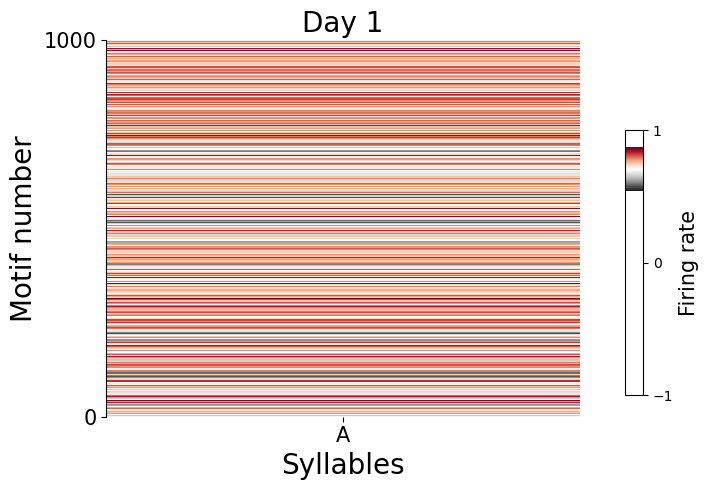

In [ ]:
def plot_HL_motifs_on_day(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(6,5))

    cm = plt.cm.get_cmap('RdGy_r')
    plot_array = obj.bg_all[day, :, :, 1].reshape(N_DAILY_MOTIFS, N_SYLL)
    im = ax1.imshow(plot_array, cmap=cm, aspect='auto', interpolation='none')

    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
    cbar = figure.colorbar(im, cax=cbar_ax)
    cbar.set_label('Firing rate', fontsize=15)
    cbar.set_ticks([-1, 0, 1])

    ax1.set_ylim(0, 1000)
    ax1.set_yticks([1000, 0])
    ax1.tick_params(labelsize=15)
    ax1.set_xticks(range(N_SYLL), [i for i in alphabets[:N_SYLL]])
    ax1.set_xlabel('Syllables', fontsize=20)    
    ax1.set_ylabel('Motif number', fontsize=20)
    ax1.set_title(f'Day {day}', fontsize=20)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  
    ax1.spines['bottom'].set_visible(False)
    plt.tight_layout()
plot_HL_motifs_on_day(obj, 1)
print(obj.ra_all.shape) 

In [ ]:
# plot_trajectory(0) 
# plot_trajectory(1)
# # plot_dw_day(0)
# plot_output
        
# ra_all = obj.generate_results(i)
# obj.plot_results(i)


# def build_and_run(seed, annealing, plot):
#     tqdm.write(f" Random seed is {seed}")
#     np.random.seed(seed)
#     obj = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
#     obj.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING)
#     remove_prev_files()
#     for i in range(N_SYLL):
#         obj.save_trajectory(i)
#         obj.save_results(i)
#         if ANNEALING:
#             obj.save_dw_day(i)
#     return np.mean(obj.rewards[:,-100:], axis=1)